# Transfer Learning using Tensorflow 2

In [ ]:
# Downloadng and becoming one with the data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
import os

dataset_path = "../datasets/10_food_classes_10_percent"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"dirpath: { dirpath } { len(filenames) }")

dirpath: ../datasets/10_food_classes_10_percent 0
dirpath: ../datasets/10_food_classes_10_percent/test 0
dirpath: ../datasets/10_food_classes_10_percent/test/fried_rice 250
dirpath: ../datasets/10_food_classes_10_percent/test/grilled_salmon 250
dirpath: ../datasets/10_food_classes_10_percent/test/hamburger 250
dirpath: ../datasets/10_food_classes_10_percent/test/chicken_wings 250
dirpath: ../datasets/10_food_classes_10_percent/test/ramen 250
dirpath: ../datasets/10_food_classes_10_percent/test/sushi 250
dirpath: ../datasets/10_food_classes_10_percent/test/ice_cream 250
dirpath: ../datasets/10_food_classes_10_percent/test/chicken_curry 250
dirpath: ../datasets/10_food_classes_10_percent/test/steak 250
dirpath: ../datasets/10_food_classes_10_percent/test/pizza 250
dirpath: ../datasets/10_food_classes_10_percent/train 0
dirpath: ../datasets/10_food_classes_10_percent/train/fried_rice 75
dirpath: ../datasets/10_food_classes_10_percent/train/grilled_salmon 75
dirpath: ../datasets/10_food_cl

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = dataset_path + '/train/'
test_dir = dataset_path + '/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")
test_data_10_percent = test_datagen.flow_from_directory(directory=test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")


2024-06-22 12:57:21.387646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 12:57:22.978095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

### Setting up Callbacks

In [5]:
import datetime
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras


def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: { log_dir }")
    return tensorboard_callback

## Creating models using Tensorflow Hub

In [6]:
def create_model(model_url, num_classes=10):
    feature_extraction_layer = hub.KerasLayer(model_url, 
                                             trainable=False, 
                                             name="feature_extraction_layer", 
                                             input_shape=IMAGE_SHAPE+(3, ))
    
    model = keras.Sequential([
        feature_extraction_layer,
        keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

### Plot Loss Curves

In [7]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, )
    plt.plot(val_loss, )
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(accuracy, )
    plt.plot(val_accuracy, )
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

### Resnet50

In [8]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

2024-06-22 12:57:27.122813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 12:57:27.171977: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  steps_per_epoch=len(train_data_10_percent),
                                  epochs=5,
                                  validation_data=test_data_10_percent,
                                  validation_steps=int(0.25*len(test_data_10_percent)))

Epoch 1/5
24/24 [==============================] - 136s 5s/step - loss: 1.9632 - accuracy: 0.3400 - val_loss: 1.2250 - val_accuracy: 0.6102
Epoch 2/5
24/24 [==============================] - 120s 5s/step - loss: 0.8784 - accuracy: 0.7467 - val_loss: 0.8479 - val_accuracy: 0.7467
Epoch 3/5
24/24 [==============================] - 113s 5s/step - loss: 0.6007 - accuracy: 0.8280 - val_loss: 0.7243 - val_accuracy: 0.7730
Epoch 4/5
24/24 [==============================] - 111s 5s/step - loss: 0.4665 - accuracy: 0.8800 - val_loss: 0.7078 - val_accuracy: 0.7483
Epoch 5/5
24/24 [==============================] - 114s 5s/step - loss: 0.3676 - accuracy: 0.9240 - val_loss: 0.6643 - val_accuracy: 0.7829


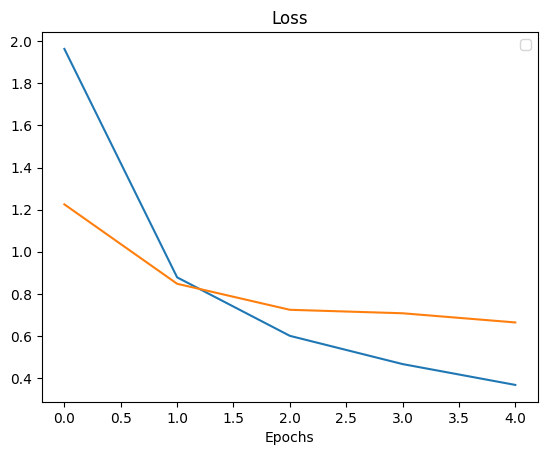

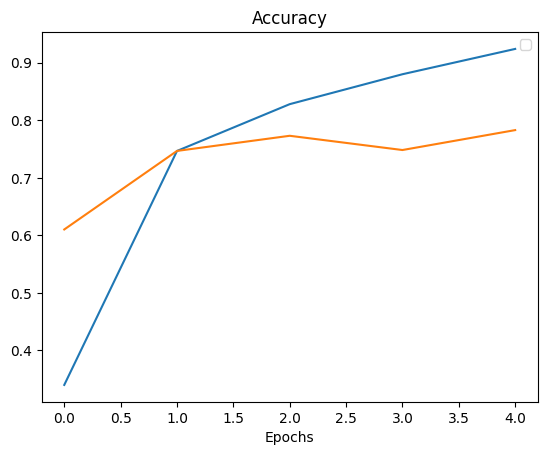

In [12]:
plot_loss_curves(resnet_history)

### EfficientNet

In [13]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [14]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  steps_per_epoch=len(train_data_10_percent),
                                  epochs=5,
                                  validation_data=test_data_10_percent,
                                  validation_steps=int(0.25*len(test_data_10_percent)),
                                  callbacks=create_tensorboard_callback(dir_name="../datasets/tensorflow_hub",
                                                                        experiment_name="EfficientNetb0"))

Saving TensorBoard log files to: ../datasets/tensorflow_hub/EfficientNetb0/20240622-130742
Epoch 1/5
24/24 [==============================] - 59s 2s/step - loss: 1.8969 - accuracy: 0.4067 - val_loss: 1.3533 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 46s 2s/step - loss: 1.0986 - accuracy: 0.7840 - val_loss: 0.8612 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 45s 2s/step - loss: 0.7468 - accuracy: 0.8400 - val_loss: 0.7209 - val_accuracy: 0.8310
Epoch 4/5
24/24 [==============================] - 47s 2s/step - loss: 0.6037 - accuracy: 0.8613 - val_loss: 0.6256 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 45s 2s/step - loss: 0.5312 - accuracy: 0.8853 - val_loss: 0.5712 - val_accuracy: 0.8503


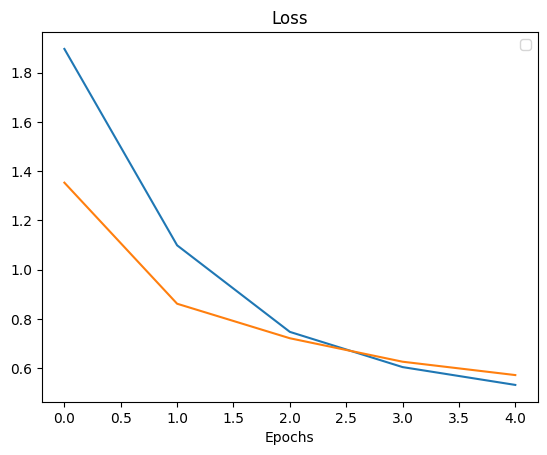

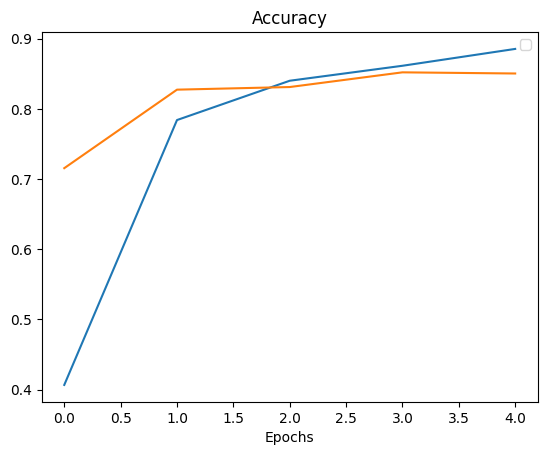

In [15]:
plot_loss_curves(efficientnet_history)